### Importing Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import littleballoffur as lb
import random
import cdlib
import networkit

In [2]:
def loadGraph(path):
    G = nx.Graph()
    with open(path) as f:
        for line in f:
            if line.startswith("#"):
                continue
            u, v = map(int, line.strip().split("\t"))
            G.add_edge(u, v)
    return G

def loadCommunity(path, k = None):
    community = {}
    node = set()
    with open(path) as f:
        for id, nodes in enumerate(f):
            if (k is not None) and (id >= k):
                break
            community[id] = list(map(int, nodes.strip().split("\t"))) 
            node.update(set(community[id]))
    return community, node

def inducedSubgraph(G, nodes):
    H = G.subgraph(nodes)
    return H
    

In [3]:
G_DBLP = loadGraph("F:/D/Python/IITGN/CS 328 Introduction to Data Science/Project/CS328-SparseCommunityDetection/Networks/DBLP/com-dblp.ungraph.txt")
communities, nodes = loadCommunity("F:/D/Python/IITGN/CS 328 Introduction to Data Science/Project/CS328-SparseCommunityDetection/Networks/DBLP/com-dblp.top5000.cmty.txt", k = 150)
G_ind_DBLP = inducedSubgraph(G_DBLP, nodes)

print("Number of nodes: ", G_DBLP.number_of_nodes())
print("Number of edges: ", G_DBLP.number_of_edges())
print("Number of communities: ", len(communities))
print("Number of nodes in induced subgraph: ", G_ind_DBLP.number_of_nodes())
print("Number of edges in induced subgraph: ", G_ind_DBLP.number_of_edges())

Number of nodes:  317080
Number of edges:  1049866
Number of communities:  150
Number of nodes in induced subgraph:  1420
Number of edges in induced subgraph:  4609


In [4]:
def plotGraph(graph, title:str = "Graph", with_labels = False, node_size = 5):
    fig = plt.figure(figsize = (12,8))
    nx.draw(graph,with_labels = with_labels, pos = nx.spring_layout(graph), node_size = node_size)
    plt.title(title)
    plt.show()

### Exploring Graph Sampling based on Random Walks 

Metropolis-Hastings Algorithm (MHRW) 

In [44]:
def metropolis_hastings_algorithm(graph:nx.Graph, sampling_ratio):
    seed_node = np.random.choice(np.array(graph.nodes()))
    current_node = seed_node
    visited_nodes = [current_node]
    num_edges = 0
    patience = 0
    alpha = 0.3

    H = nx.Graph()
    while num_edges < int(graph.number_of_edges()*sampling_ratio):
        if patience == 10:
            current_node = np.random.choice(np.array(graph.nodes()))
            visited_nodes.append(current_node)
            patience = 0
            alpha = alpha**1.5
        neighbors = graph.neighbors(current_node)
        new_node = np.random.choice(list(neighbors))
        if not H.has_edge(current_node, new_node):
            r = np.random.uniform(alpha,1)
            if r < (graph.degree(new_node)/graph.degree(current_node)):
                H.add_edges_from([(current_node, new_node)])
                current_node = new_node
                num_edges += 1
                print(num_edges)
                visited_nodes.append(new_node)
            else:
                current_node = current_node
        else:
            current_node = current_node
            patience += 1
    
    H.add_nodes_from(graph.nodes)
    return set(visited_nodes), H

In [ ]:
visited_nodes, subgraph = metropolis_hastings_algorithm(G_ind_DBLP, sampling_ratio = 0.5)
plotGraph(subgraph, node_size = 12, title = "Metropolis Hastings Based Edge Sampling")

SRW (Simple Random Walk)

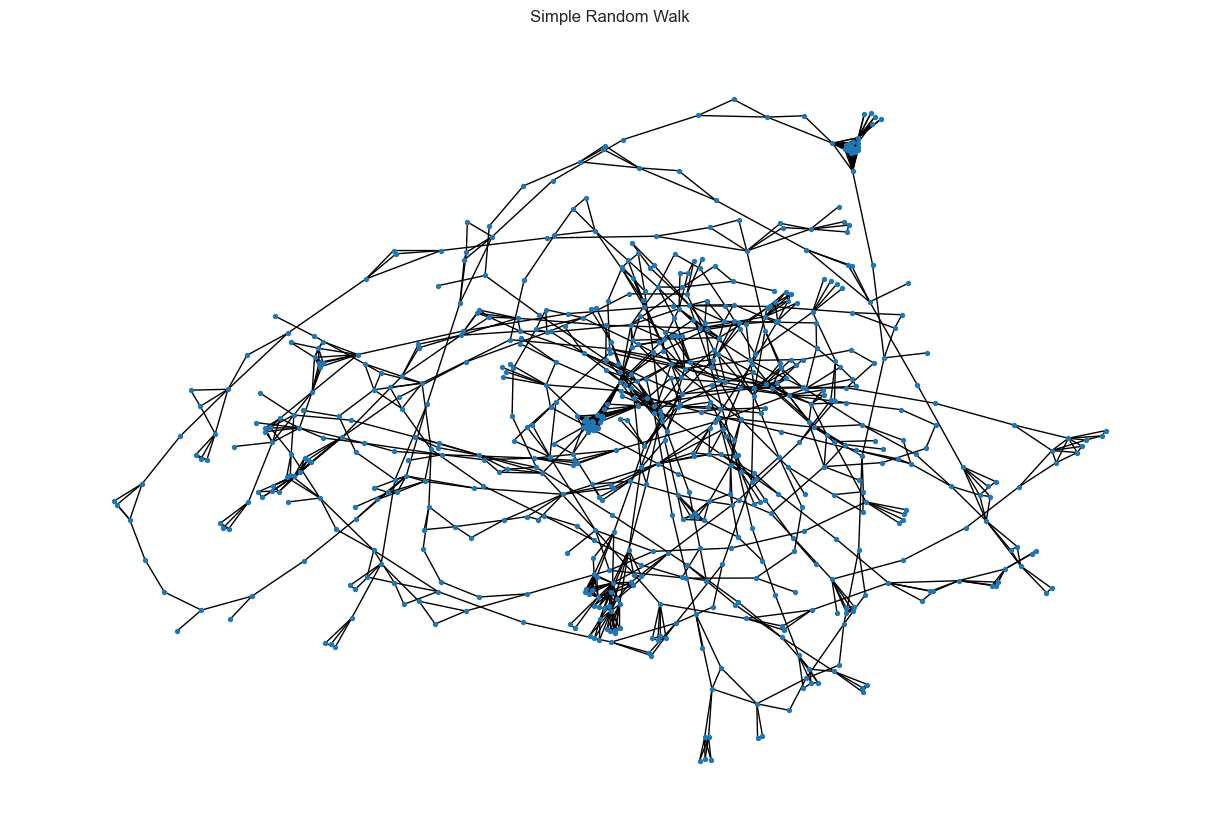

In [37]:
def SRW(graph, total_budget = 1000, seed=None):
    if seed is None:
        seed = np.random.choice(list(graph.nodes()))  # Choose a random seed if not provided

    current_node = seed
    visited_nodes = [current_node]

    budget = 0
    while budget < total_budget:
        neighbors = list(graph.neighbors(current_node))
        if not neighbors:
            break  # If the current node has no neighbors, break out of the loop

        next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
        visited_nodes.append(next_node)

        current_node = next_node
        budget += 1
    
    H = graph.subgraph(set(visited_nodes))
    return visited_nodes, H

random_walk_path, subgraph = SRW(G_DBLP, total_budget = 1000, seed = 1)
plotGraph(subgraph, node_size = 8, title = "Simple Random Walk")

RWR (Random Walk with Restart)

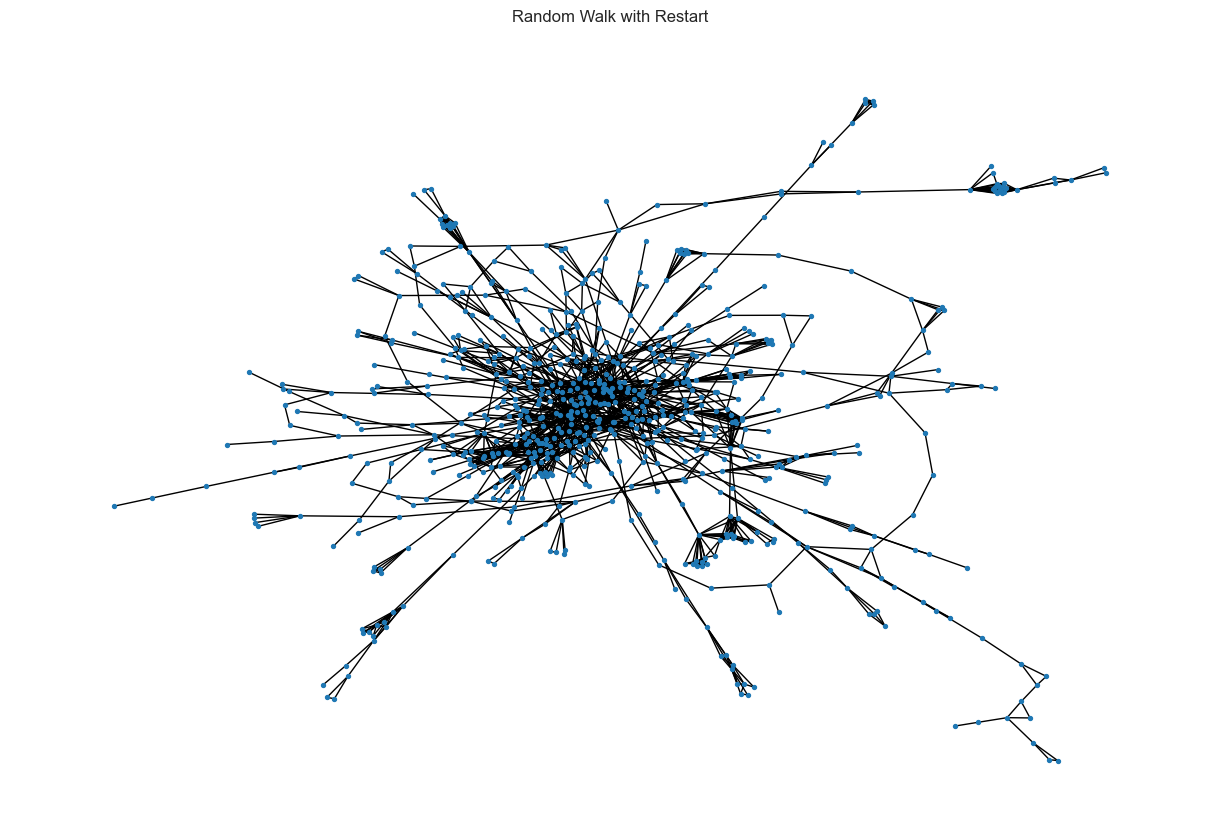

In [38]:
def RWR(graph, total_budget = 1000, restart_prob=0.1, seed=None):
    if seed is None:
        seed = np.random.choice(list(graph.nodes()))  # Choose a random seed if not provided

    current_node = seed
    visited_nodes = [current_node]

    budget = 0
    while budget < total_budget:
        r = np.random.uniform(0, 1)  # Sample a random number between 0 and 1
        if r < restart_prob:
            current_node = seed  # Restart the walk from the seed node
        else:
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:
                break  # If the current node has no neighbors, break out of the loop

            next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
            visited_nodes.append(next_node)
            current_node = next_node

        budget += 1
    H = graph.subgraph(set(visited_nodes))
    return visited_nodes, H

rwr_path, subgraph = RWR(G_DBLP, total_budget = 1000, restart_prob = 0.1, seed  =1)
plotGraph(subgraph, node_size = 8, title = "Random Walk with Restart")

MIRW (Multiple Indpendent Random Walks)

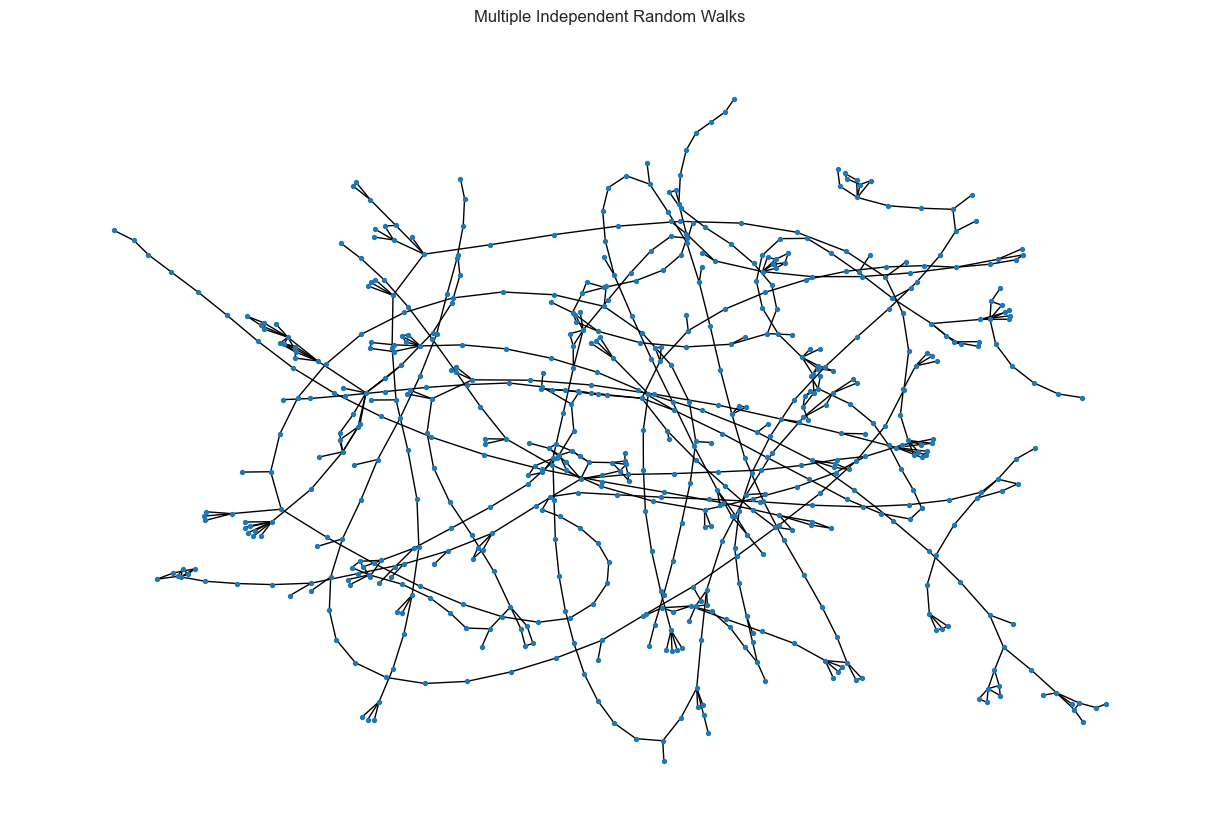

In [46]:
def MIRW(graph, l = 10, budget_per_walk = 100):
    edge_sets = [set() for _ in range(l)]  # Initialize edge sets for each walk
    node_sets = [set() for _ in range(l)]  # Initialize node sets for each walk

    for k in range(l):
        seed = np.random.choice(list(graph.nodes()))  # Choose a random seed for each walk
        current_node = seed
        node_sets[k].add(current_node)

        budget = 0
        while budget < budget_per_walk:
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:
                break  # If the current node has no neighbors, break out of the loop

            next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
            edge_sets[k].add((current_node, next_node))
            node_sets[k].add(next_node)
            current_node = next_node
            budget += 1

    # Combine edge sets and node sets from all walks
    combined_edge_set = set().union(*edge_sets)
    combined_node_set = set().union(*node_sets)

    subgraph = nx.Graph()
    subgraph.add_nodes_from(combined_node_set)
    subgraph.add_edges_from(combined_edge_set)
    return combined_node_set, combined_edge_set, subgraph

nodes, edges, subgraph = MIRW(G_DBLP, l = 10, budget_per_walk = 100)
plotGraph(subgraph, node_size = 8, title = "Multiple Independent Random Walks")

Multi-Dimensional Random Walk (MDRW)

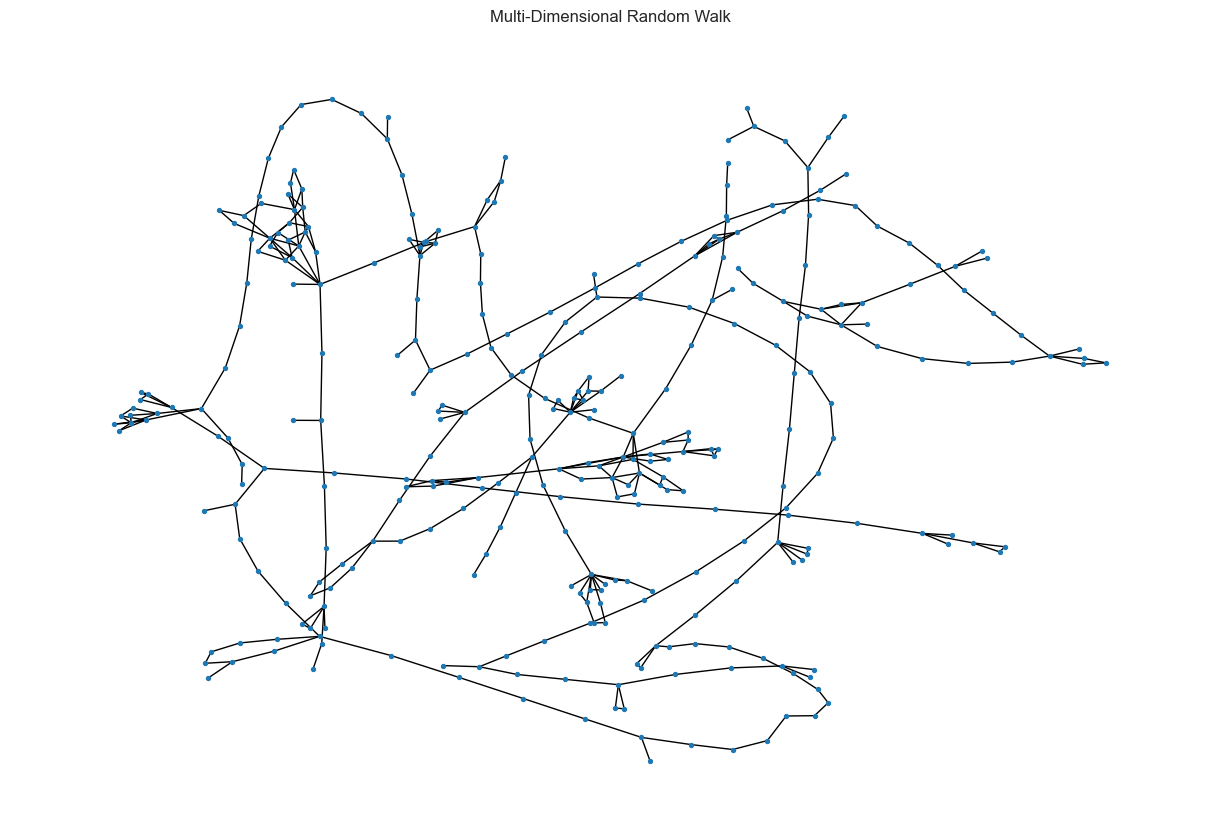

In [59]:
def MDRW(graph, m, total_budget):
    L = np.random.choice(list(graph.nodes()), m)  # Choose m nodes as the initial vector L
    edge_set = set()  # Initialize the edge set
    node_set = set()  # Initialize the node set

    for k in range(total_budget):
        degrees = np.array([graph.degree(node) for node in L])
        probabilities = degrees/np.sum(degrees)
        chosen_node = np.random.choice(L, p=probabilities, size = 1)[0]  # Choose a node proportional to its degree
        neighbors = list(graph.neighbors(chosen_node))
        if not neighbors:
            break  # If the chosen node has no neighbors, break out of the loop

        next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
        edge_set.add((chosen_node, next_node))
        node_set.add(next_node)

        # Replace chosen_node by next_node in the vector L
        L[L == chosen_node] = next_node

    subgraph = nx.Graph()
    subgraph.add_nodes_from(node_set)
    subgraph.add_edges_from(edge_set)

    return node_set, edge_set, subgraph


nodes, edges, subgraph = MDRW(G_DBLP, m = 5, total_budget = 500)
plotGraph(subgraph, node_size = 8, title = "Multi-Dimensional Random Walk")

### Newer Sampling Techniques

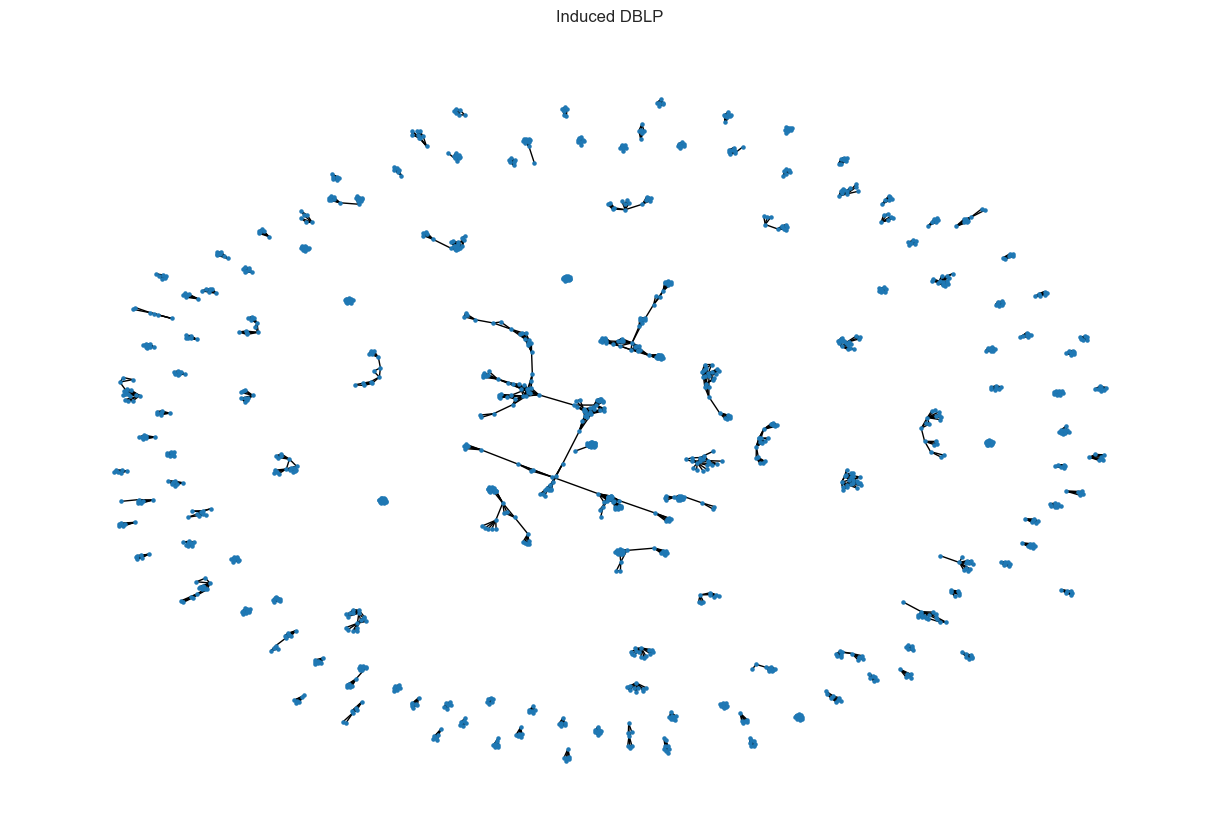

In [35]:
plotGraph(G_ind_DBLP, 'Induced DBLP')

#### Degree-based Edge Sampling

In [73]:
def degree_based_edge_sampling(graph, sampling_ratio):
    """
    Perform Degree-based Edge Sampling on the input graph.

    Parameters:
        graph (networkx.Graph): The input graph.
        sampling_ratio (float): The percentage of edges to retain (between 0 and 1).

    Returns:
        networkx.Graph: The sampled graph.
    """
    sampled_graph = nx.Graph()
    total_edges = graph.number_of_edges()

    # Create a list of edges sorted by the product of their endpoint degrees
    edge_degrees = [(edge, 1/(graph.degree(edge[0]) * graph.degree(edge[1]))) for edge in graph.edges()]
    edge_degrees.sort(key=lambda x: x[1], reverse=True)
    edges = np.zeros((total_edges, 2))
    for i, e in enumerate(edge_degrees):
        edges[i] = e[0]
    
    # Determine the number of edges to retain based on the sampling ratio
    num_edges_to_retain = int(total_edges * sampling_ratio)

    # Sample the edges based on their degrees
    sorted_edge_prob = np.zeros(total_edges)
    for idx, edge_info in enumerate(edge_degrees):
        sorted_edge_prob[idx] = edge_info[1]
    sorted_edge_prob = sorted_edge_prob/np.sum(sorted_edge_prob)
    sampled_edges = np.random.choice(np.arange(total_edges), p = sorted_edge_prob, size = num_edges_to_retain, replace=False)

    # Add the sampled edges and original nodes to the sampled graph
    sampled_edges = edges[sampled_edges]
    sampled_graph.add_edges_from(sampled_edges)
    sampled_graph.add_nodes_from(graph.nodes)

    return sampled_graph

# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.20

# Perform Degree-based Edge Sampling
sampled_G = degree_based_edge_sampling(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes in sampled graph:", len(sampled_G.nodes))

Original graph edges: 4609
Sampled graph edges: 921
Number of nodes in sampled graph: 1420


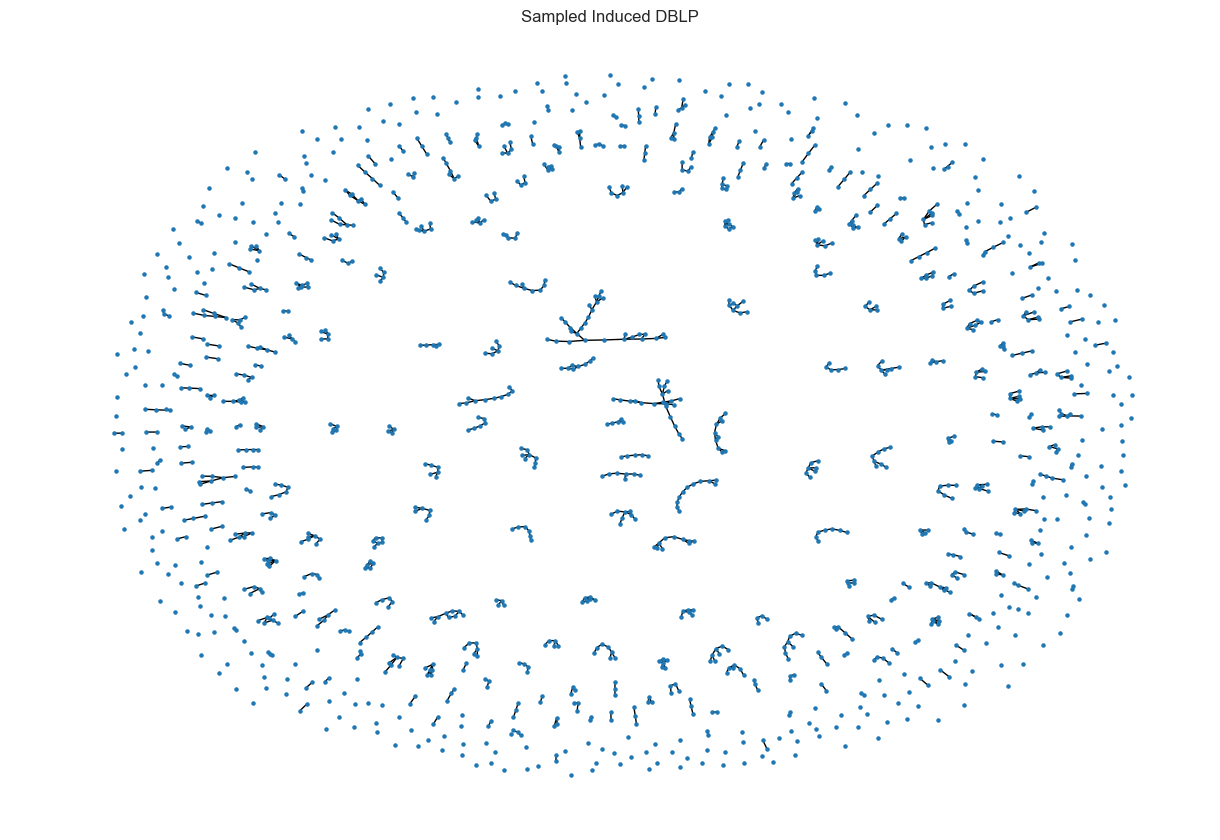

In [74]:
plotGraph(sampled_G, "Sampled Induced DBLP")

In [66]:
def degree_based_edge_sampling(graph, sampling_ratio):
    H = nx.Graph()
    edge_deg_prod = []
    edges = []
    for edge in graph.edges():
        edges.append(edge)
        edge_deg_prod.append(graph.degree(edge[0])*graph.degree(edge[1]))
    indices = np.argsort(edge_deg_prod)
    p = np.sort(np.array(edge_deg_prod))[::-1]/np.sum(edge_deg_prod)
    sampled_indices = np.random.choice(indices, p = p, replace = False, size = int(graph.number_of_edges()*sampling_ratio))
    sampled_edges = np.array(edges)[sampled_indices]
    H.add_edges_from(sampled_edges)
    H.add_nodes_from(graph.nodes)
    return H

# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.2

# Perform Degree-based Edge Sampling
sampled_G = degree_based_edge_sampling(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes in sampled graph:", len(sampled_G.nodes))

Original graph edges: 4609
Sampled graph edges: 921
Number of nodes in sampled graph: 1420


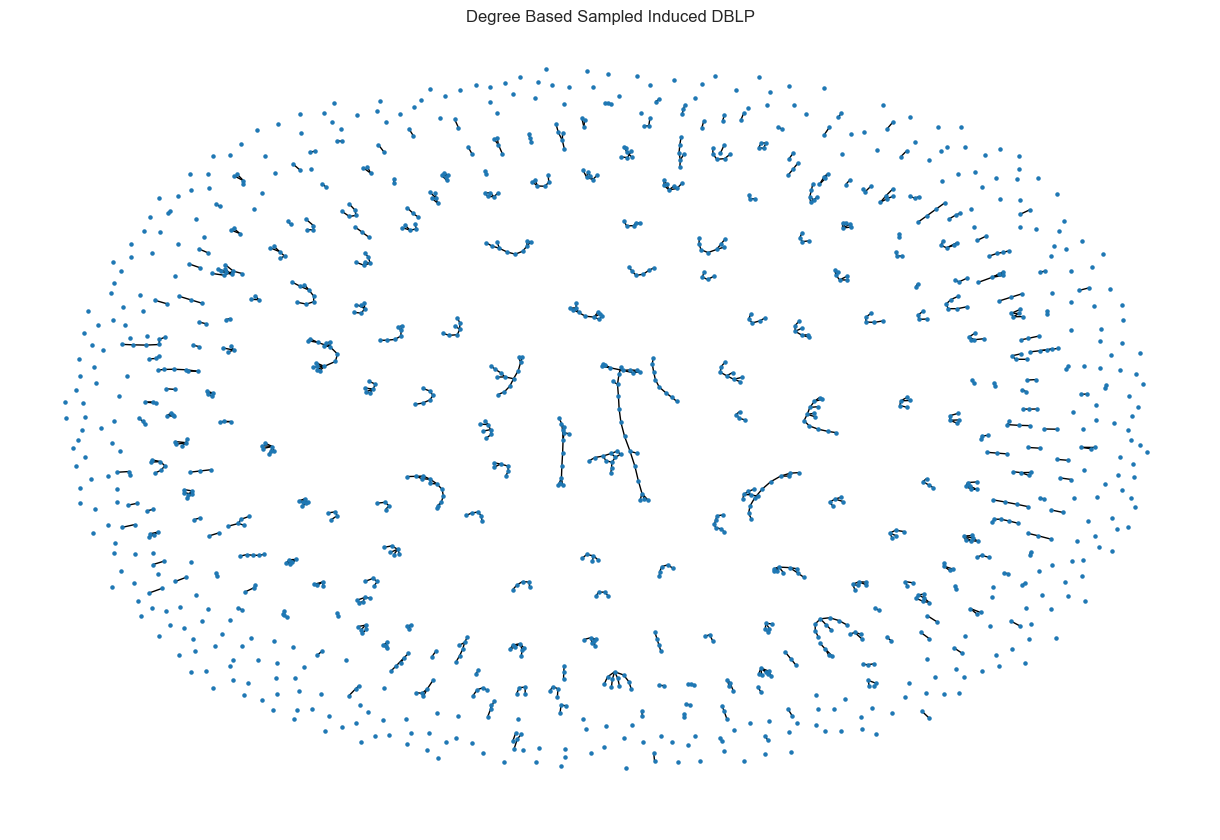

In [67]:
plotGraph(sampled_G, "Degree Based Sampled Induced DBLP")

#### Clustering Coefficients Biased Sampling

In [77]:
def clustering_coeffs_edge_sampling(graph, sampling_ratio):
    H = nx.Graph()
    edge_cc_prod = []
    edges = []
    clustering_coeffs = nx.clustering(graph)
    for edge in graph.edges():
        edges.append(edge)
        edge_cc_prod.append(clustering_coeffs[edge[0]]+clustering_coeffs[edge[1]])
    indices = np.argsort(edge_cc_prod)[::-1]
    p = np.sort(np.array(edge_cc_prod))[::-1]/np.sum(edge_cc_prod)
    sampled_indices = np.random.choice(indices, p = p, replace = False, size = int(graph.number_of_edges()*sampling_ratio))
    sampled_edges = np.array(edges)[sampled_indices]
    H.add_edges_from(sampled_edges)
    H.add_nodes_from(graph.nodes)
    return H

# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.2

# Perform Degree-based Edge Sampling
sampled_G = clustering_coeffs_edge_sampling(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes in sampled graph:", len(sampled_G.nodes))

Original graph edges: 4609
Sampled graph edges: 921
Number of nodes in sampled graph: 1420


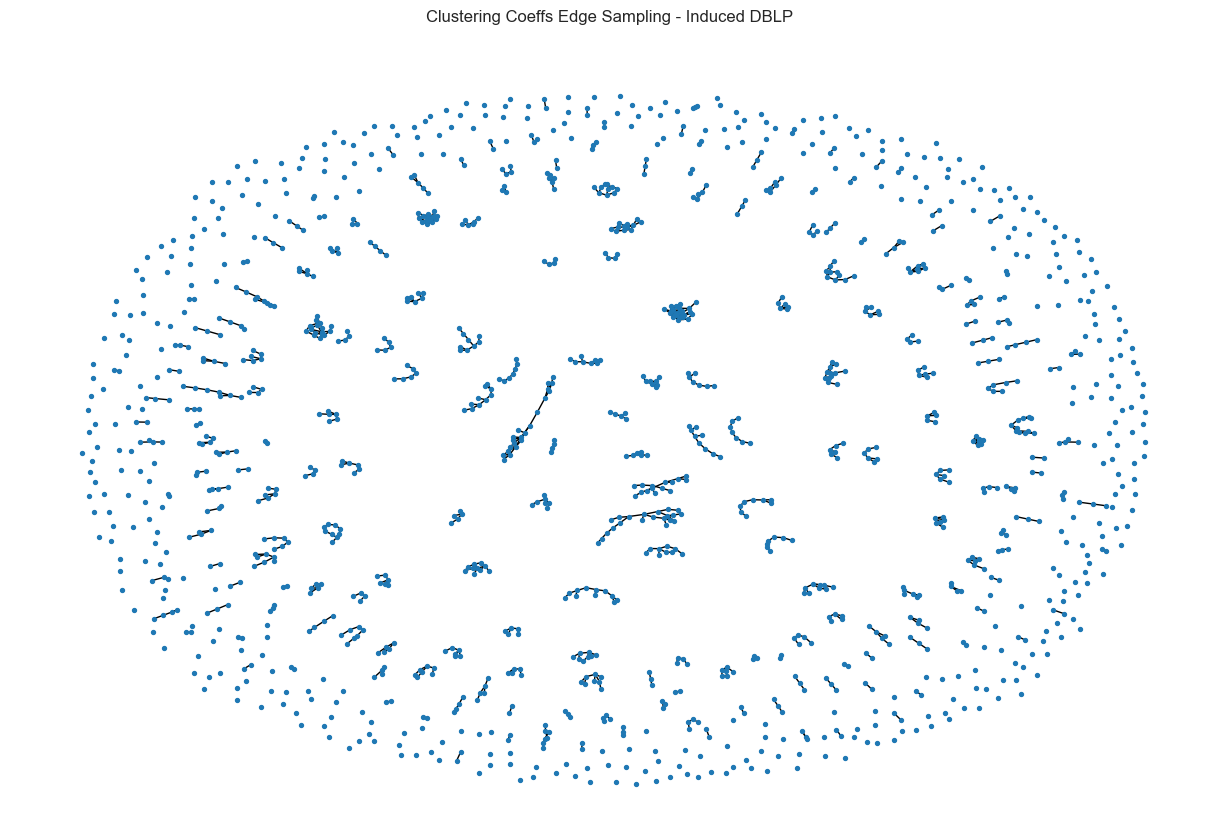

In [78]:
plotGraph(sampled_G, "Clustering Coeffs Edge Sampling - Induced DBLP", node_size=8)

#### Spanning Tree Edge Sampling

In [79]:
def spanning_tree_sampling(graph, sampling_ratio):
    """
    Perform Spanning Tree Sampling on the input graph.

    Parameters:
        graph (networkx.Graph): The input graph.
        sampling_ratio (float): The percentage of edges to retain (between 0 and 1).

    Returns:
        networkx.Graph: The sampled graph.
    """
    # Construct a minimum spanning tree of the original graph
    spanning_tree = nx.minimum_spanning_tree(graph)

    # Convert the spanning tree to a graph
    sampled_graph = nx.Graph(spanning_tree.edges())

    # Get the total number of edges in the original graph
    total_edges = graph.number_of_edges()

    # Calculate the number of edges to retain based on the sampling ratio
    num_edges_to_retain = int(total_edges * sampling_ratio)

    # If the spanning tree has fewer edges than the required number of retained edges,
    # randomly sample additional edges from the original graph to meet the quota
    if sampled_graph.number_of_edges() < num_edges_to_retain:
        remaining_edges = num_edges_to_retain - sampled_graph.number_of_edges()
        remaining_edges_to_sample = random.sample(list(graph.edges()), remaining_edges)
        sampled_graph.add_edges_from(remaining_edges_to_sample)

    return sampled_graph

# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.1

# Perform Spanning Tree Sampling
sampled_G = spanning_tree_sampling(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes in sampled graph:", len(sampled_G.nodes))

Original graph edges: 4609
Sampled graph edges: 1284
Number of nodes in sampled graph: 1420


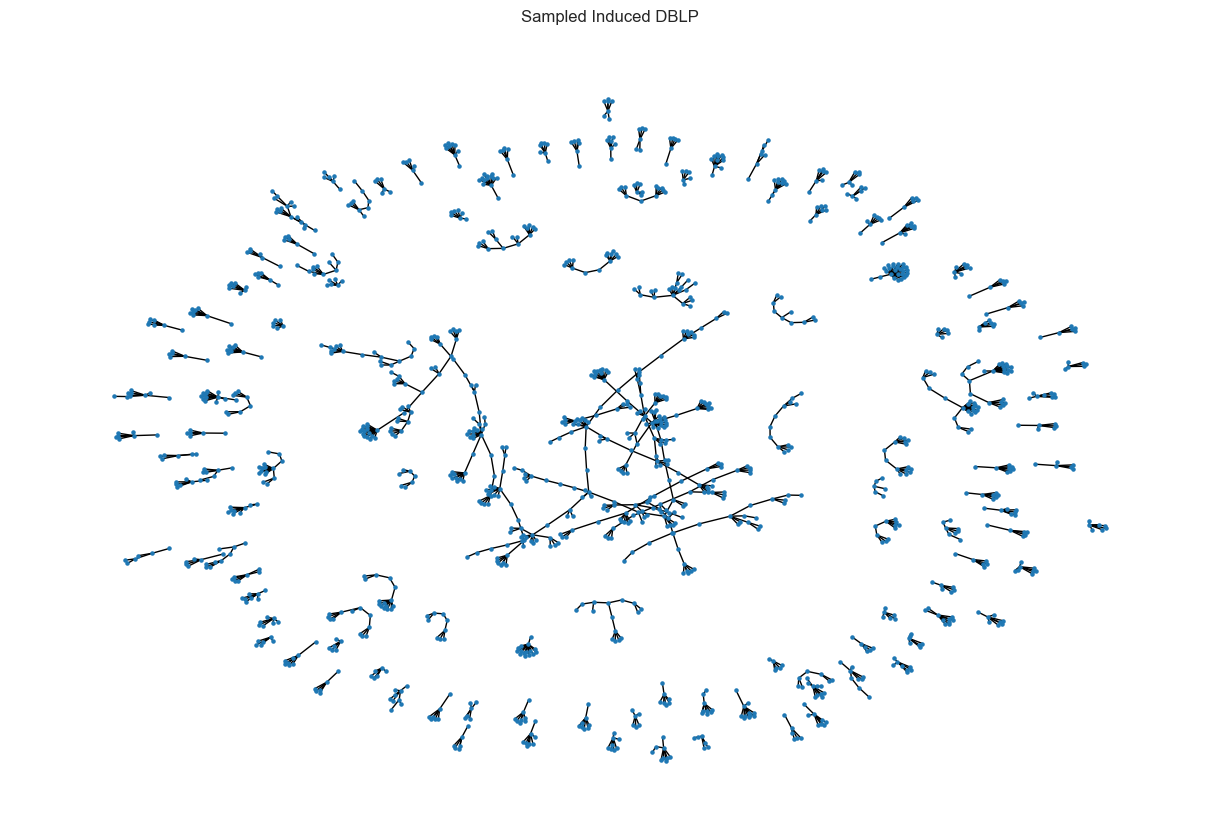

In [80]:
plotGraph(sampled_G, "Sampled Induced DBLP")

In [ ]:
import networkx as nx

def t_spanner(graph, t):
    t_spanner_graph = nx.Graph()
    
    for u in graph.nodes():
        for v in graph.nodes():
            if u != v:
                # Calculate the shortest path distance between u and v in the original graph
                shortest_path_distance = nx.shortest_path_length(graph, source=u, target=v)
                
                # If the shortest path distance is within the factor of t times the Euclidean distance, add the edge to the t-spanner
                if shortest_path_distance <= t:
                    t_spanner_graph.add_edge(u, v)
    
    return t_spanner_graph

# Example usage:
# Create an example graph
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])

# Set the factor t for the t-spanner
t = 2

# Generate the t-spanner graph
t_spanner_graph = t_spanner(G, t)

# Print the edges in the t-spanner graph
print("Edges in the t-spanner graph:")
print(list(t_spanner_graph.edges()))

#### PageRank based Sampling

In [103]:
def pagerank_based_edge_sampling(graph:nx.Graph, sampling_ratio):
    """
    Perform PageRank-based Edge Sampling on the input graph.

    Parameters:
        graph (networkx.Graph): The input graph.
        sampling_ratio (float): The percentage of edges to retain (between 0 and 1).

    Returns:
        networkx.Graph: The sampled graph.
    """
    # Compute PageRank scores for nodes in the graph
    pagerank_scores = nx.pagerank(graph)

    # Sort nodes based on PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
    # Initialize a list to store sampled edges
    sampled_edges = []

    # Iterate over sorted nodes and sample edges incident to high PageRank nodes
    for node, _ in sorted_nodes:
        neighbors = list(graph.neighbors(node))
        num_edges_to_sample = int(len(neighbors) * sampling_ratio)
        sampled_edges.extend([(node, neighbor) for neighbor in random.sample(neighbors, num_edges_to_sample)])

    sampled_graph = nx.Graph()
    # Create the sampled graph
    sampled_graph.add_edges_from(sampled_edges)
    sampled_graph.add_nodes_from(graph)

    return sampled_graph
# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.39

# Perform PageRank-based Edge Sampling
sampled_G = pagerank_based_edge_sampling(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes:", sampled_G.number_of_nodes())

Original graph edges: 4609
Sampled graph edges: 2334
Number of nodes: 1420


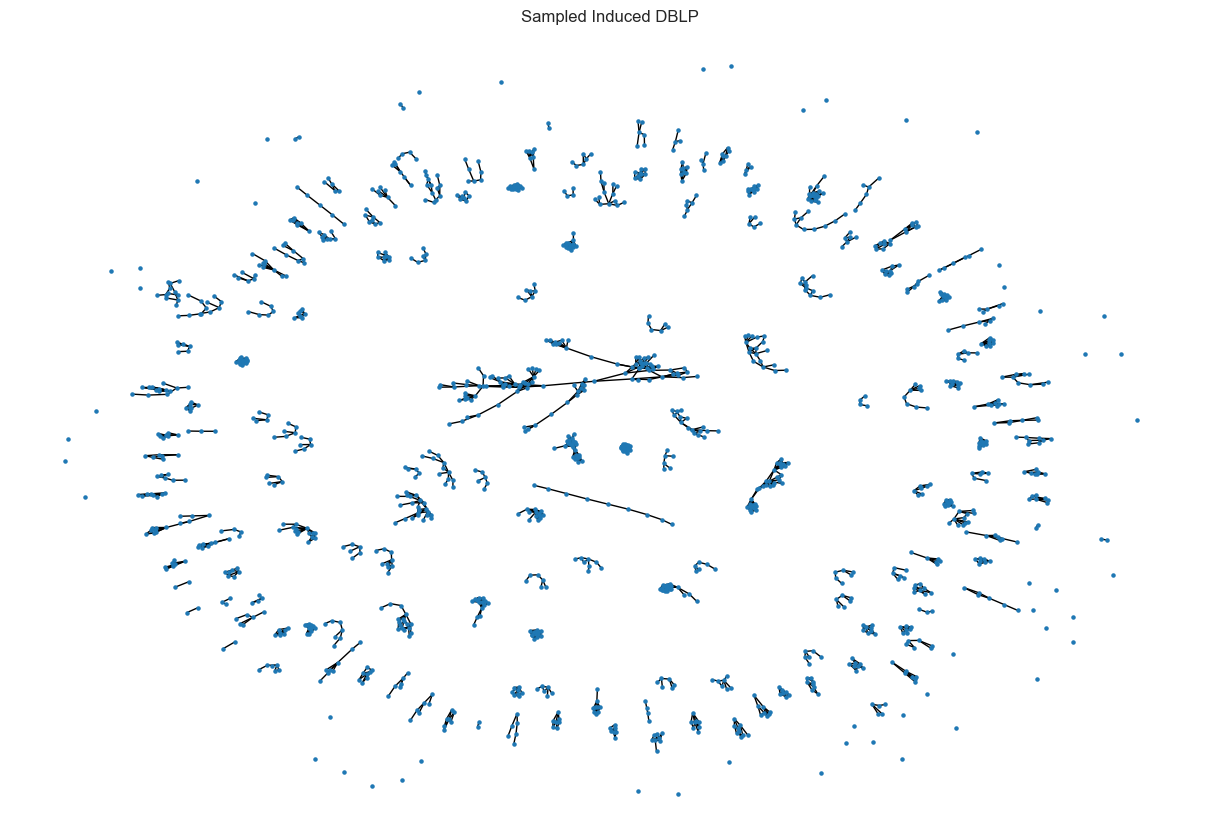

In [104]:
plotGraph(sampled_G, "Sampled Induced DBLP")

#### Effective Resistance Sampling

In [85]:
def effective_resistance_sampling_1(graph:nx.Graph, sampling_ratio):
    list_sampled_edges = []
    l = 0
    for component in list(nx.connected_components(graph)):
        subgraph = nx.subgraph(graph, component)
        edges = np.array(subgraph.edges())
        resistances = []
        for i in range(edges.shape[0]):
            resistances.append(nx.resistance_distance(subgraph, edges[i,0], edges[i,1]))
        sorted_edges = edges[np.argsort(resistances)]
        list_sampled_edges.append(sorted_edges[:int(subgraph.number_of_edges()*sampling_ratio)])
        l += int(subgraph.number_of_edges()*sampling_ratio)
    sampled_edges = np.zeros(shape=(l,2))
    p = 0
    for arr in list_sampled_edges:
        sampled_edges[p: p+len(arr), :] = arr
        p += len(arr)
    H = nx.Graph()
    H.add_edges_from(sampled_edges)
    H.add_nodes_from(graph.nodes)
    return H

# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.2

# Perform PageRank-based Edge Sampling
sampled_G = effective_resistance_sampling_1(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes in sampled graph:", len(sampled_G.nodes))

Original graph edges: 4609
Sampled graph edges: 885
Number of nodes in sampled graph: 1420


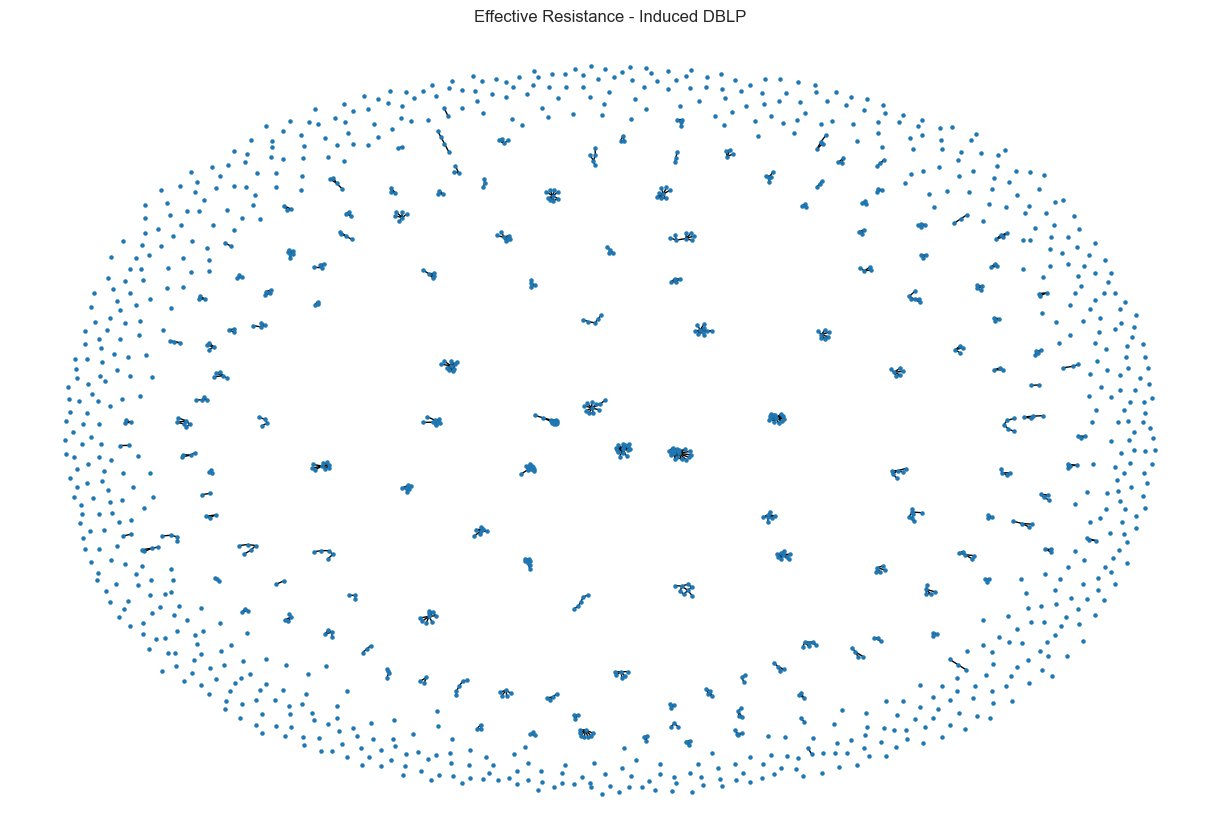

In [86]:
plotGraph(sampled_G, "Effective Resistance 1 - Induced DBLP")

In [87]:
def effective_resistance_sampling_2(graph:nx.Graph, sampling_ratio):
    list_sampled_edges = []
    l = 0
    for component in list(nx.connected_components(graph)):
        subgraph = nx.subgraph(graph, component)
        edges = np.array(subgraph.edges())
        resistances = []
        for i in range(edges.shape[0]):
            resistances.append(nx.resistance_distance(subgraph, edges[i,0], edges[i,1]))
        sorted_edges = edges[np.argsort(resistances)[::-1]]
        list_sampled_edges.append(sorted_edges[:int(subgraph.number_of_edges()*sampling_ratio)])
        l += int(subgraph.number_of_edges()*sampling_ratio)
    sampled_edges = np.zeros(shape=(l,2))
    p = 0
    for arr in list_sampled_edges:
        sampled_edges[p: p+len(arr), :] = arr
        p += len(arr)
    H = nx.Graph()
    H.add_edges_from(sampled_edges)
    H.add_nodes_from(graph.nodes)
    return H

# Example usage:
# Create an example graph
G = G_ind_DBLP

# Set the sampling ratio (e.g., retain 50% of edges)
sampling_ratio = 0.2

# Perform PageRank-based Edge Sampling
sampled_G = effective_resistance_sampling_2(G, sampling_ratio)

# Print the number of edges in the original and sampled graphs
print("Original graph edges:", G.number_of_edges())
print("Sampled graph edges:", sampled_G.number_of_edges())
print("Number of nodes in sampled graph:", len(sampled_G.nodes))

Original graph edges: 4609
Sampled graph edges: 885
Number of nodes in sampled graph: 1420


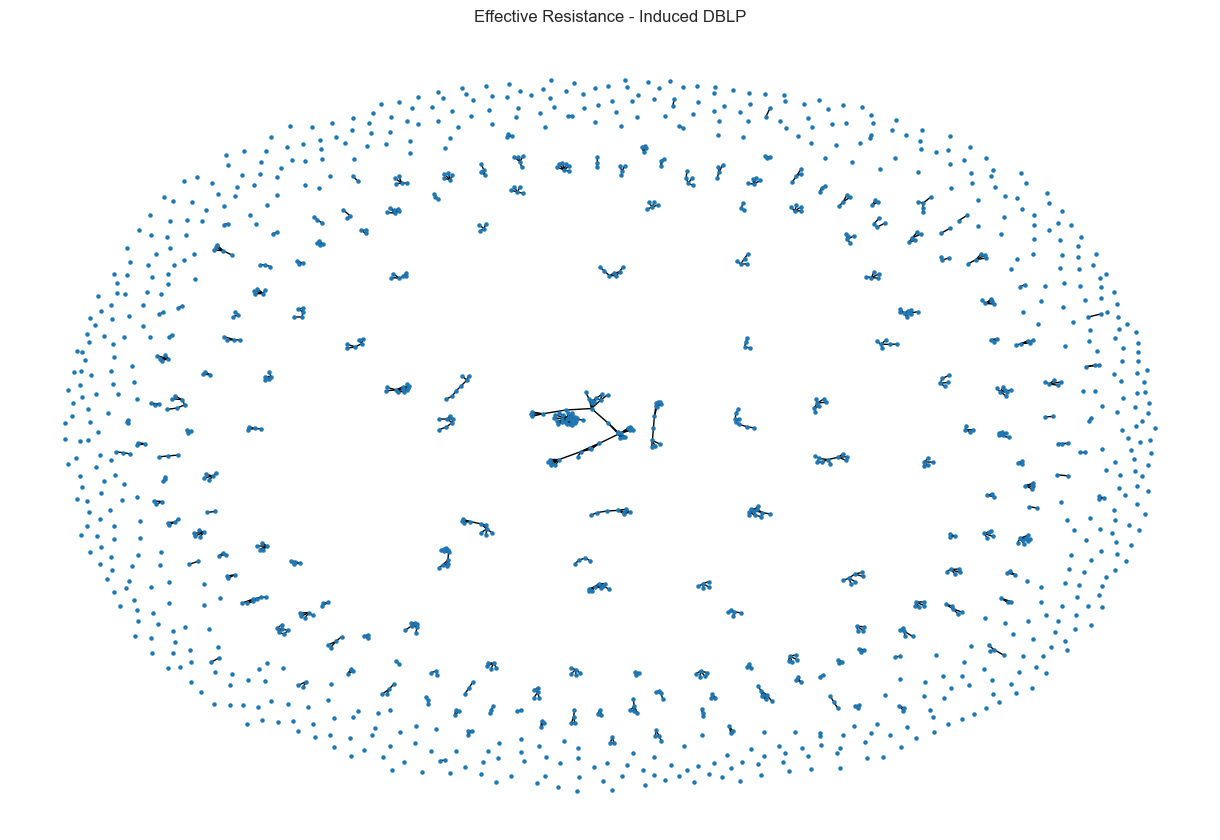

In [88]:
plotGraph(sampled_G, "Effective Resistance 2 - Induced DBLP")

#### NetworKit Forest Fire Sampling
The Forest Fire sparsifier implements a variant of the Forest Fire sparsification approach that is based on random walks.

In [115]:
# Initialize the algorithm
## Hyperparameters: 
##  a) The probability  pf = 0.6 that the neighbor nodes will burn as well
##  b) The target burn ratio, tebr = 5.0 which states that forest fire will burn until (tebr * m) edges have been burnt (where m is the number of edges of G).

fireSparsifier =  networkit.sparsification.ForestFireSparsifier(0.6,5.0) 

# Get sparsified graph
r = 0.5
nk_G_ind_DBLP = networkit.nxadapter.nx2nk(G_ind_DBLP)
nk_G_ind_DBLP.indexEdges()
fireGraph = fireSparsifier.getSparsifiedGraphOfSize(nk_G_ind_DBLP ,r)
# Print the number of edges in the original and sampled graphs
print("Original graph edges:", nk_G_ind_DBLP.numberOfEdges())
print("Sampled graph edges:", fireGraph.numberOfEdges())
print("Number of nodes in sampled graph:", fireGraph.numberOfNodes())

Original graph edges: 4609
Sampled graph edges: 2154
Number of nodes in sampled graph: 1420


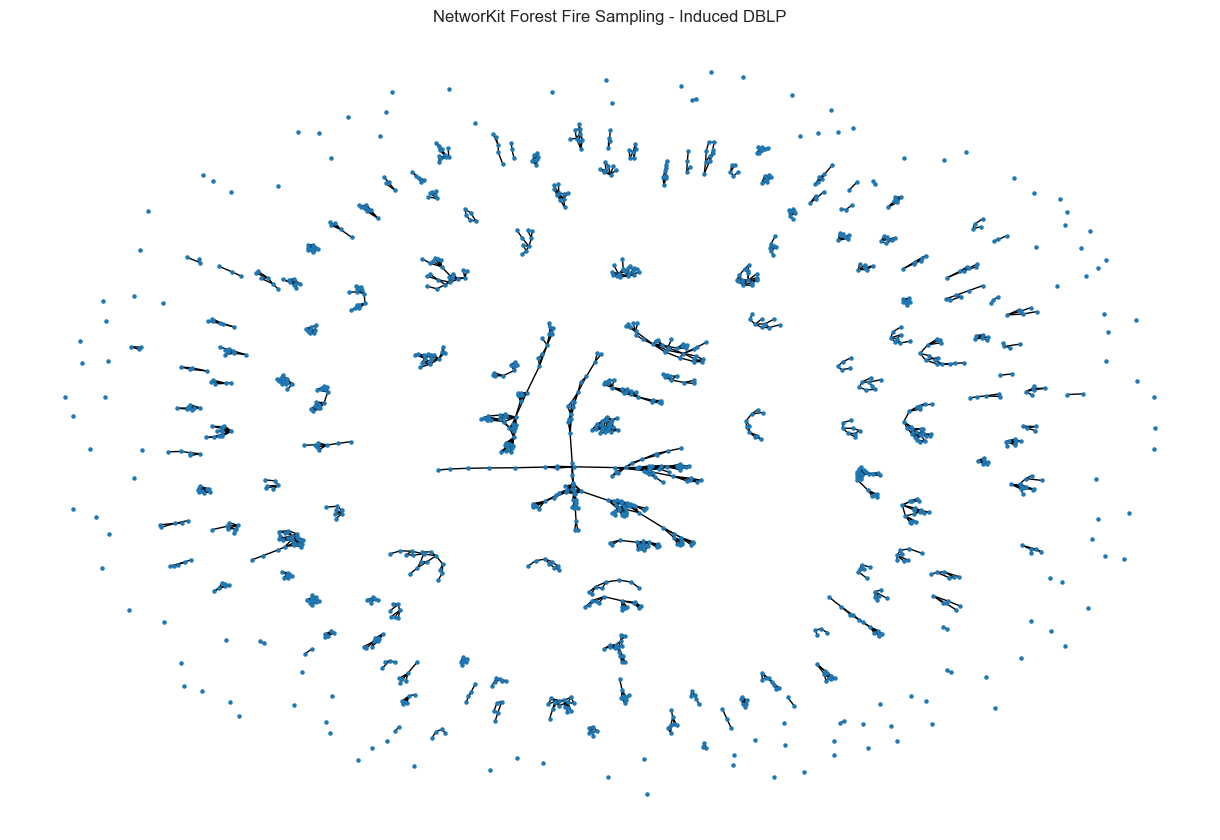

In [103]:
plotGraph(networkit.nxadapter.nk2nx(fireGraph), "NetworKit Forest Fire Sampling - Induced DBLP")

#### $^{*}$ NetworKit Local Degree Sparsifier
The local degree sparsification strategy is based on the idea of hub nodes. For each edge of the graph, it determines the maximum parameter value such that the edge is still contained in the sparsified graph.

In [117]:
# Initialize the algorithm
localDegSparsifier = networkit.sparsification.LocalDegreeSparsifier()

# Get sparsified graph
r = 0.5
nk_G_ind_DBLP = networkit.nxadapter.nx2nk(G_ind_DBLP)
nk_G_ind_DBLP.indexEdges()
localDegGraph  = localDegSparsifier.getSparsifiedGraphOfSize(nk_G_ind_DBLP ,r)
# Print the number of edges in the original and sampled graphs
print("Original graph edges:", nk_G_ind_DBLP.numberOfEdges())
print("Sampled graph edges:", localDegGraph .numberOfEdges())
print("Number of nodes in sampled graph:", localDegGraph .numberOfNodes())

Original graph edges: 4609
Sampled graph edges: 2358
Number of nodes in sampled graph: 1420


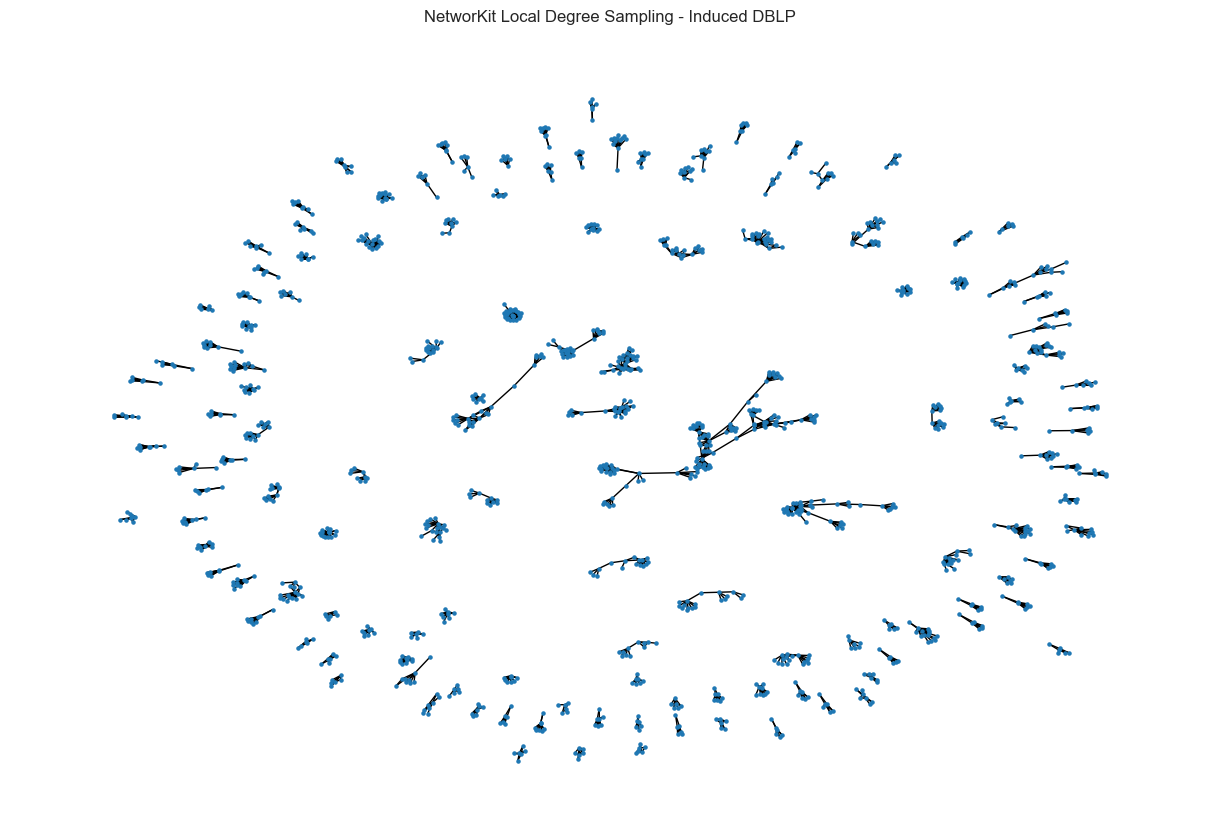

In [108]:
plotGraph(networkit.nxadapter.nk2nx(localDegGraph), "NetworKit Local Degree Sampling - Induced DBLP")

#### $^{*}$ NetworKit Local Similarity Sparsifier

In [120]:
# Initialize the algorithm
similaritySparsifier = networkit.sparsification.LocalSimilaritySparsifier()

# Get sparsified Graph
r = 0.5
nk_G_ind_DBLP = networkit.nxadapter.nx2nk(G_ind_DBLP)
nk_G_ind_DBLP.indexEdges()
similarityGraph  = similaritySparsifier.getSparsifiedGraphOfSize(nk_G_ind_DBLP ,r)
# Print the number of edges in the original and sampled graphs
print("Original graph edges:", nk_G_ind_DBLP.numberOfEdges())
print("Sampled graph edges:", similarityGraph.numberOfEdges())
print("Number of nodes in sampled graph:", similarityGraph.numberOfNodes())

Original graph edges: 4609
Sampled graph edges: 2304
Number of nodes in sampled graph: 1420


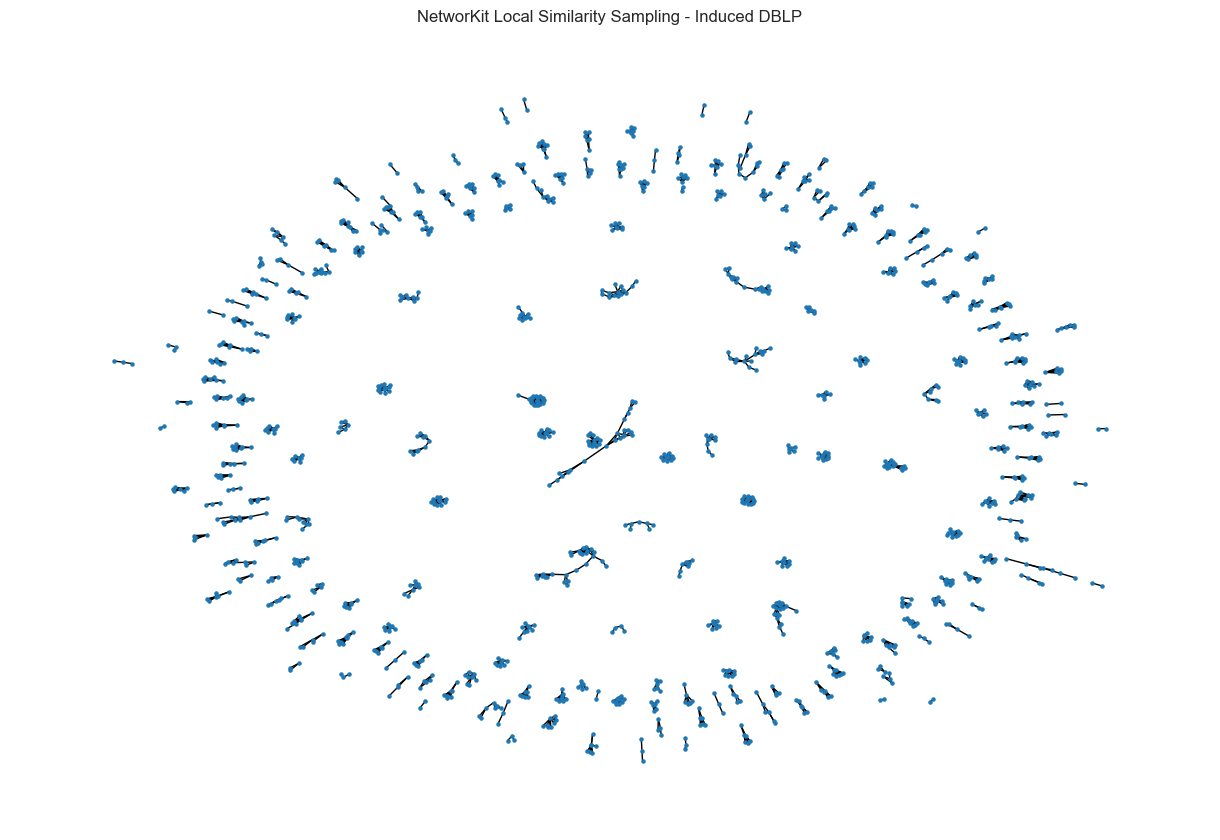

In [121]:
plotGraph(networkit.nxadapter.nk2nx(similarityGraph), "NetworKit Local Similarity Sampling - Induced DBLP")

#### $^{*}$ NerworKit Structural Clustering Algorithm for Networks (SCAN) Similarity Sampling
This algorithm is a Structural Clustering Algorithm for Networks (SCAN) whose goal is to find clusters, hubs, and outliers in large networks.

In [128]:
# Initialize the algorithm
scanSparsifier = networkit.sparsification.SCANSparsifier()

# Get sparsified Graph
r = 0.50
nk_G_ind_DBLP = networkit.nxadapter.nx2nk(G_ind_DBLP)
nk_G_ind_DBLP.indexEdges()
scanGraph   = scanSparsifier.getSparsifiedGraphOfSize(nk_G_ind_DBLP ,r)
# Print the number of edges in the original and sampled graphs
print("Original graph edges:", nk_G_ind_DBLP.numberOfEdges())
print("Sampled graph edges:", scanGraph .numberOfEdges())
print("Number of nodes in sampled graph:", scanGraph .numberOfNodes())

Original graph edges: 4609
Sampled graph edges: 2334
Number of nodes in sampled graph: 1420


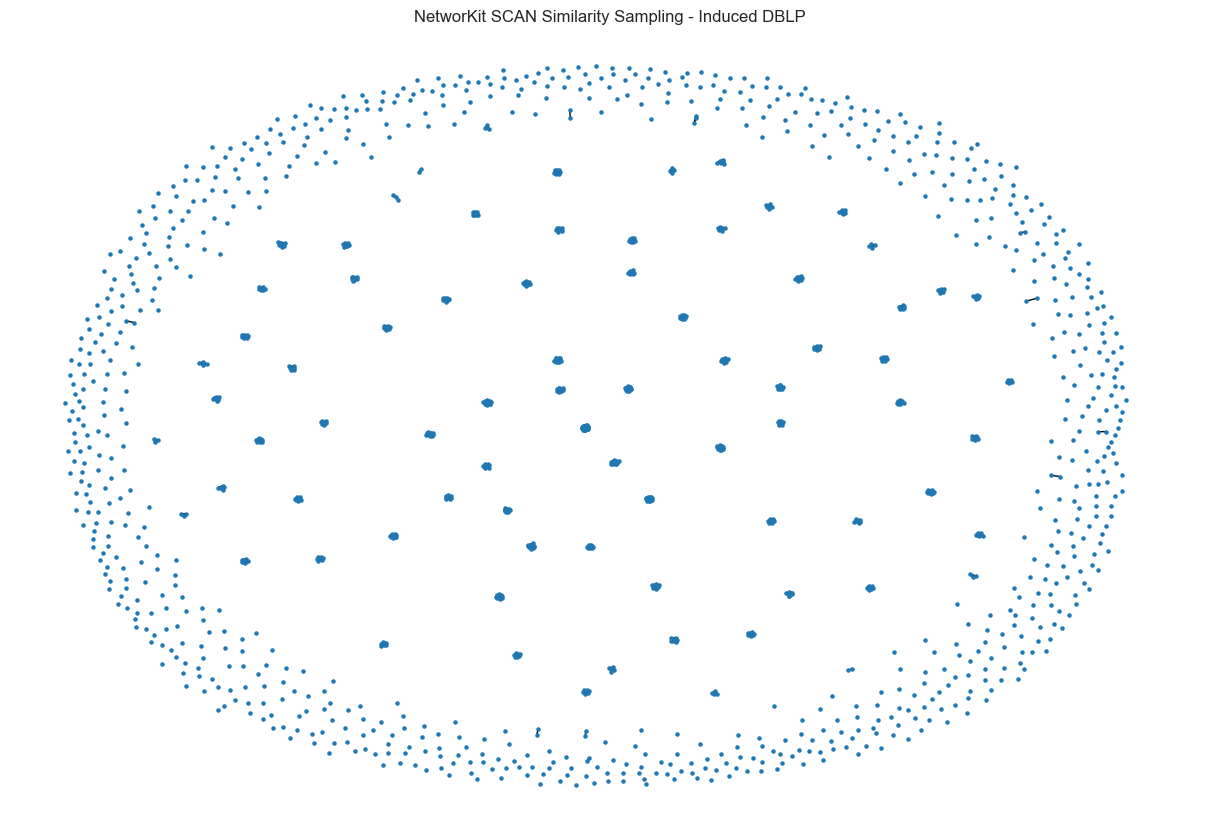

In [129]:
plotGraph(networkit.nxadapter.nk2nx(scanGraph), "NetworKit SCAN Similarity Sampling - Induced DBLP")

#### $^{*}$ NetworKit Simmelian Sparsifier Non Parametric
This is an implementation of the parametric variant of Simmelian Backbones.

In [136]:
# Initialize the algorithm
simmelianSparsifier = networkit.sparsification.SimmelianSparsifierNonParametric()

# Get sparsified Graph
r = 0.50

nk_G_ind_DBLP = networkit.nxadapter.nx2nk(G_ind_DBLP)
nk_G_ind_DBLP.indexEdges()
simleianGraph   = simmelianSparsifier.getSparsifiedGraphOfSize(nk_G_ind_DBLP ,r)
# Print the number of edges in the original and sampled graphs
print("Original graph edges:", nk_G_ind_DBLP.numberOfEdges())
print("Sampled graph edges:", simleianGraph.numberOfEdges())
print("Number of nodes in sampled graph:", simleianGraph.numberOfNodes())

Original graph edges: 4609
Sampled graph edges: 4139
Number of nodes in sampled graph: 1420


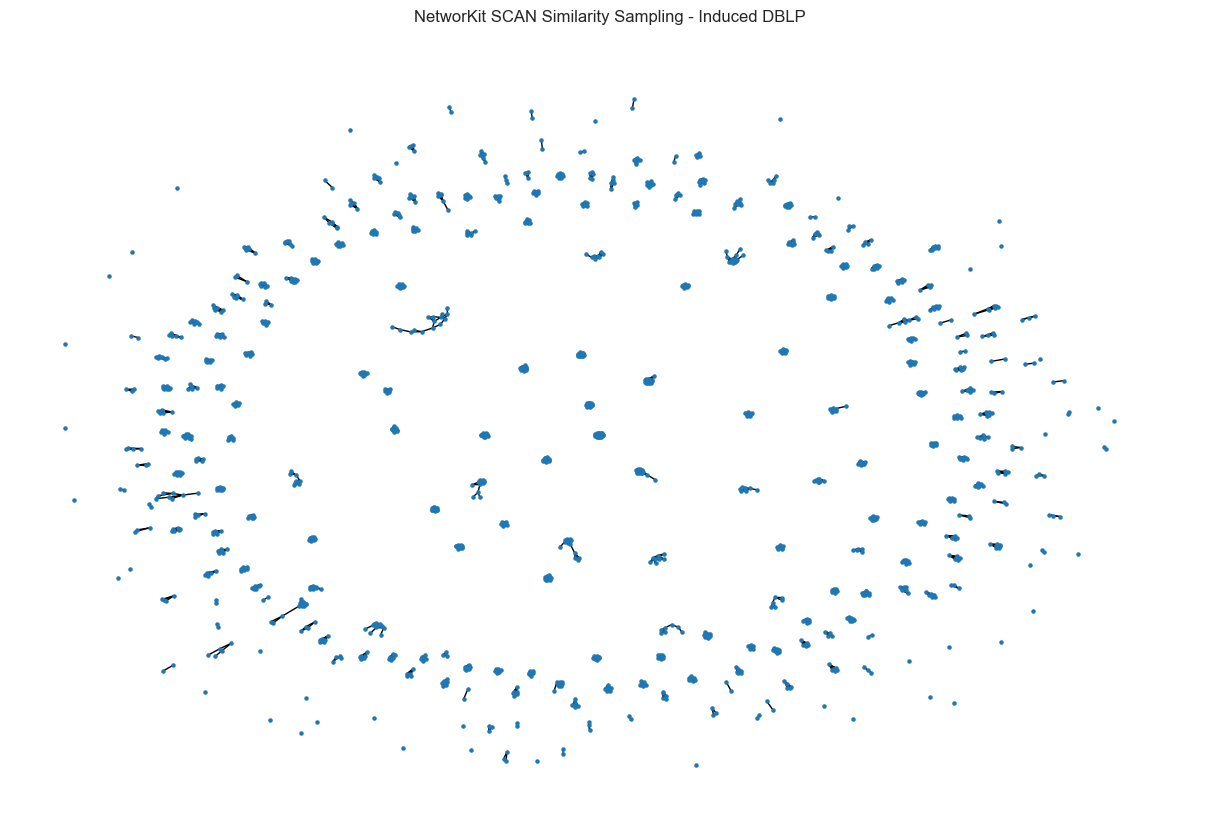

In [133]:
plotGraph(networkit.nxadapter.nk2nx(simleianGraph), "NetworKit SCAN Similarity Sampling - Induced DBLP")

#### Other NetwroKit Sparsifiers

In [143]:
# networkit.sparsification.TriangleSparsifier()
# networkit.sparsification.AlgebraicDistanceSparsifier()
# networkit.sparsification.JaccardSimilaritySparsifier()
# networkit.sparsification.QuadrilateralSimmelianSparsifier()